# Toxic Detection

## Prueba Técnica: Mercado Libre

**Marzo 2023**

*César Daniel Garrido Urbano*


## Descripción

El objetivo es construir un sistema para detectar automáticamente textos que contienen lenguaje ofensivo (inclusive de género, raza, etc...) o vulgar.

Para esto debes generar un modelo de clasificación utilizando un esquema basado en árboles de decisión. (Por ejemplo: Random Forest, XGBoost, LightGBM, etc...).

El proceso de desarrollo debe seguir el flujo completo de modelado en machine learning (análisis de datos, feature engineering, selección de modelo, métricas) con reporte de resultados y proceso. Toda decisión tomada dentro del pipeline debe ser agregada al reporte.

Luego de haber seleccionado el mejor modelo de clasificación, para el reporte, haz un análisis comparativo de los dos mejores modelos que hayas obtenido con la métrica que consideres se adapta mejor al problema.


# Exploración Inicial de los datos

Visualización, preprocesamiento (tokenización) y limpieza de los datos.

In [1]:
# Main libraries
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Set pandas columns option
pd.set_option('display.max_colwidth', 500)
pd.set_option("max_rows", 30)

# Import Simpsons data
raw_df = pd.read_csv('data_toxic.csv')

# Glimpse at the dataset
raw_df

,message,label
0,"Hola, dale actualizar a la pagina o la tecla F5",0
1,Ningún mujer te va a dejar por un error. porque todos somos humanos y el algún momento la cagamos pero siempre hay la oportunidad de mejorar en la cagas que uno hace y más si te hace feliz,1
2,"Entonces, si está haciendo una correspondencia en R ^ 2, ¿cómo dibujaría G (x) = {y es un elemento de R2 tal que el producto escalar de x e y es 0} si G (3,4)",0
3,victoria con el pelito corto me voy a matar,1
4,@LoloPeniche Periodista!!!!!\nEs una puta verdulera la HDSPTM... https://t.co/6wyiTra4ko,1
...,...,...
514550,Argentina: *apoya a la Alemania Nazi en la guerra*\nAlemania: *pierde la guerra*\nArgentina teniendo que explicarle la situación al resto del mundo: https://t.co/eQo4Pqru2r,1
514551,"La rata esta de @robertomadrazo invitando a votar, ya pasó no??, para darle aire a su partido corrupto y hablando de tiranías. No mames ratero que te compre quien no te conoce. https://t.co/T7Xm9ZLJxE",1
514552,No dale no hay problema muchísimas gracias no me sabía ese dato no encuentro problema alguno solo me surgió esa duda espero no haber incómodado muchas gracias,0
514553,"Mi nombre es ""onassis amaya cc 84083683",0


In [3]:
raw_df.groupby(['label']).count()

,message
label,
0,295937
1,218618


In [4]:
# Simplifiación temporal del problema (50.000 mensajes)
sample_df = raw_df.head(50000)
y = sample_df.label

## Pre-procesamiento de los datos

### Tokenización

In [5]:
# NLTK 
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [6]:
# Función para estandarizar el preprocesamiento.

def preprocess_text(text, tokenizer=None, stemmer=None, stop_words=None):
    """ Aplica un preprocesamiento estandar a un mensaje (text), tokenizandolo y limpiando los caracteres.
    
    Args:
        text (str): Mensaje a ser preprocesado
        tokenizer (nltk.tokenize.Tokenizer): Tokenizador (Objeto para convertir mensajes en tokens).
        stemmer (nltk.stem.Stemmer): Stemmer (Objeto que normaliza o reduce las palabras a su raiz).
        stop_words ([str]): Lista de palabras a ser removidas por ser tan repetidas (tipicamente articulos).
    
    Returns:
        preprocessed_text ([str]): Lista de tokens preprocesados del mensaje inicial.
    
    """
    
    # Tokenizacion y estandarizacion en minusculas
    text_tk = tokenizer.tokenize(text.lower())
    
    # Remover signos de puntuación + stop words + URLs
    relevant_tk = []
    for tk in text_tk:
        if (tk not in string.punctuation+'¿') and (tk not in stop_words) and ('http' not in tk):
            relevant_tk.append(tk)   
    
    # Stemmer (Cortar finalizacion de la palabra)
    #processed_text=[]
    #for tk in relevant_tk:
    #    processed_text.append(stemmer.stem(tk))
    
    # Returns processed text
    return relevant_tk

In [7]:
# Tokenizador para tweets
tt = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
# Stemmer y stop-words en español
stemmer = SnowballStemmer('spanish')
stop_words = stopwords.words('spanish')

cleaned_msgs = []
for txt in tqdm(sample_df.message):
    # Tokenize tweets
    cleaned_msgs.append(preprocess_text(txt, tt, stemmer, stop_words))

100%|██████████| 50000/50000 [00:09<00:00, 5222.45it/s]


In [8]:
# Ejemplo de Tokenización
print("Ejemplos de Tokenización:\n")
print(sample_df.message.iloc[2]) 
print(cleaned_msgs[2])
print("")
print(sample_df.message.iloc[4]) 
print(cleaned_msgs[4])

Ejemplos de Tokenización:

Entonces, si está haciendo una correspondencia en R ^ 2, ¿cómo dibujaría G (x) = {y es un elemento de R2 tal que el producto escalar de x e y es 0} si G (3,4)
['entonces', 'si', 'haciendo', 'correspondencia', 'r', '2', 'cómo', 'dibujaría', 'g', 'x', 'elemento', 'r2', 'tal', 'producto', 'escalar', 'x', '0', 'si', 'g', '3,4']

@LoloPeniche Periodista!!!!!
Es una puta verdulera la HDSPTM... https://t.co/6wyiTra4ko
['periodista', 'puta', 'verdulera', 'hdsptm', '...']


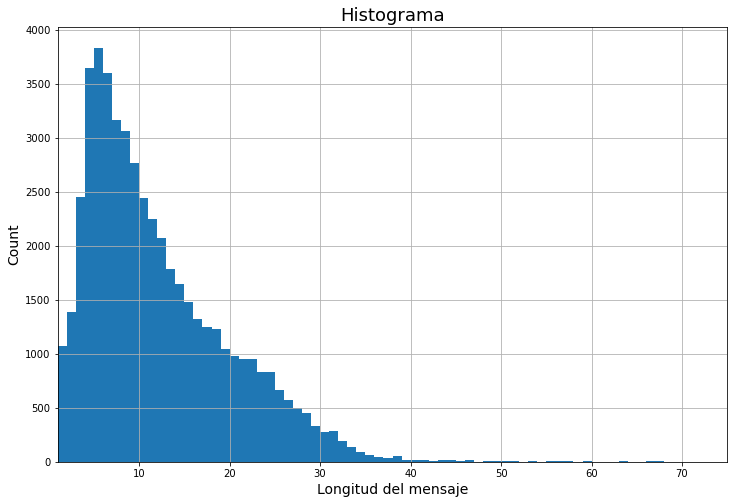

Tamaño promedio (mean) de los mensajes:
11.67194
Tamaño medio (median) de los mensajes:
9.0


In [9]:
# Histograma (Longitud de mensajes)

msgs_length = []
for x in cleaned_msgs:
    msgs_length.append(len(x))

# Number of bins
bins= np.max(np.array(msgs_length))

# Plot
fig = plt.figure(figsize=(12,8))
plt.hist(np.array(msgs_length), bins=bins)
plt.xlim([1, 75])
plt.xlabel('Longitud del mensaje', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Histograma', fontsize=18)
plt.grid(True)
plt.savefig("histogram.png")
plt.show()

# Print some metrics
print('Tamaño promedio (mean) de los mensajes:')
print(np.mean(np.array(msgs_length)))

print('Tamaño medio (median) de los mensajes:')
print(np.median(np.array(msgs_length)))

## Embeddings

Representación de las sentencias (tokens) como vectores.

In [10]:
from sklearn.decomposition import PCA, IncrementalPCA
from gensim import corpora

D:\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Modelo Bag of Words (BOW)

In [11]:
# Crear diccionario de palabras
dict_msgs = corpora.Dictionary(cleaned_msgs)
dict_msgs.filter_extremes(no_below=5, no_above=0.5)

print('Diccionario de palabras construido a partir del set de mensajes:')
print(dict_msgs)

Diccionario de palabras construido a partir del set de mensajes:
Dictionary(11463 unique tokens: ['actualizar', 'dale', 'hola', 'pagina', 'tecla']...)


In [12]:
# Crear corpus con representación BOW
corpus = []
for msg in cleaned_msgs:
    corpus.append(dict_msgs.doc2bow(msg))

In [13]:
# Crear matriz de caracteristicas BOW
X_bow = np.zeros((len(corpus), len(dict_msgs)), dtype = np.int32)

# Llenar matriz
for i, tweet in enumerate(corpus):
    for term in tweet:
        X_bow[i][term[0]] = term[1]

#### Dimentionality Reduction (PCA)

In [14]:
# PCA (Optional)

#pca = IncrementalPCA(n_components=500, batch_size=10000)
#X_bow_pca = pca.fit_transform(X_bow)

### Modelo Word2Vec

In [15]:
from gensim import models

#### Promedio

In [16]:
vec_size = 150

# Entrenar modelo W2V
w2v_model_150 = models.Word2Vec(cleaned_msgs, vector_size=vec_size, window=3, min_count=5, sg=0, negative=10, workers=10)
w2v_model_150.train(cleaned_msgs, total_examples=len(cleaned_msgs), epochs=10)

# Convertir mensajes a vectores W2V
words = set(w2v_model_150.wv.index_to_key )
X_w2v_150 = np.array([np.array([w2v_model_150.wv[i] for i in ls if i in words]) for ls in cleaned_msgs])

# Promedio de la sentencia
X_w2v_avg = []

for x in X_w2v_150:
    if len(x) == 0:
        x_avg = np.zeros(vec_size)
    else:
        x_avg = np.mean(x, axis=0)
    X_w2v_avg.append(x_avg)

<ipython-input-16-c8579120e46d>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_w2v_150 = np.array([np.array([w2v_model_150.wv[i] for i in ls if i in words]) for ls in cleaned_msgs])


#### Concatenadas

In [17]:
n_words = 20
vec_size = 50
sentence_size = n_words*vec_size

# Entrenar modelo W2V
w2v_model_50 = models.Word2Vec(cleaned_msgs, vector_size=vec_size, window=3, min_count=5, sg=0, negative=10, workers=10)
w2v_model_50.train(cleaned_msgs, total_examples=len(cleaned_msgs), epochs=10)

# Convertir mensajes a vectores W2V
words = set(w2v_model_50.wv.index_to_key )
X_w2v_50 = np.array([np.array([w2v_model_50.wv[i] for i in ls if i in words]) for ls in cleaned_msgs])

# Concatenacion de las primeras 20 palabras
X_w2v_concat = []

for x in X_w2v_50:
    x_concat = x.flatten()
    if len(x_concat) < 1:
        x_concat= np.zeros(sentence_size)
    elif len(x_concat) < sentence_size:
        x_concat = np.append(x_concat, np.zeros(sentence_size-len(x_concat)))
    elif len(x_concat) > sentence_size:
        x_concat = x_concat[0:sentence_size]
        
    X_w2v_concat.append(x_concat)

<ipython-input-17-186ec24b030e>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_w2v_50 = np.array([np.array([w2v_model_50.wv[i] for i in ls if i in words]) for ls in cleaned_msgs])


In [18]:
# Verificación de cantidad de mensajes que fallaron en la vectorización
failed_count = 0
for x in X_bow:
    if x.sum()==0:
        failed_count +=1

print("BOW")
print(f"Número de mensajes en blanco: {failed_count}")

failed_count = 0
for x in X_w2v_avg:
    if x.sum()==0:
        failed_count +=1

print()
print("W2V")
print(f"Número de mensajes en blanco: {failed_count}")

BOW
Número de mensajes en blanco: 122
W2V
Número de mensajes en blanco: 117


### Modelo Deep (Transformer Pre-Entrenado)

# Selección de Modelo

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [20]:
def train_test_models(model, X, y, model_id='Model', test_id='001'):
    """ Entrena y prueba modelo de clasificación binaria.
    
    Args:
        model (model): Modelo a ser entrenado y probado.
        X (np.array): Representación de los mensajes en vectores (BOW, Word2Vec, DeepEmbeddings)
        y (np.array): Etiqueta de la clase (0 o 1)
        model_id (str): Id para identificar modelo
    
    Returns:
        results (dict): Metricas de evaluación 
    
    """
    # Separar data en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metricas de performance
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    
    # Resultados
    results = {'Model': model_id, 'Test': test_id , 'Accuracy': accuracy,
               'Precision': precision, 'Recall': recall, 'F1-Score': f1_score}
    
    return results

## Decision Trees

In [21]:
dt_clf = DecisionTreeClassifier()

# BOW
results = train_test_models(dt_clf, X_bow, y, model_id='DT', test_id='BOW')
results_df = pd.DataFrame.from_dict([results])

# results = train_test_models(dt_clf, X_bow_pca, y, model_id='DT', test_id='BOW-PCA')
# results_df = results_df.append(results, ignore_index=True)

# Word2Vec
results = train_test_models(dt_clf, X_w2v_avg, y, model_id='DT', test_id='W2V-Avg')
results_df = results_df.append(results, ignore_index=True)

results = train_test_models(dt_clf, X_w2v_concat, y, model_id='DT', test_id='W2V-Concat')
results_df = results_df.append(results, ignore_index=True)

## RandomForest

In [22]:
rf_clf = RandomForestClassifier(verbose=1, n_jobs=-2)

# BOW
results = train_test_models(rf_clf, X_bow, y, model_id='RF', test_id='BOW')
results_df = results_df.append(results, ignore_index=True)

# results = train_test_models(rf_clf, X_bow_pca, y, model_id='RF', test_id='BOW-PCA')
# results_df = results_df.append(results, ignore_index=True)

# Word2Vec
results = train_test_models(rf_clf, X_w2v_avg, y, model_id='RF', test_id='W2V-Avg')
results_df = results_df.append(results, ignore_index=True)

results = train_test_models(rf_clf, X_w2v_concat, y, model_id='RF', test_id='W2V-Concat')
results_df = results_df.append(results, ignore_index=True)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    3

## XGBoost

In [23]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# BOW
results = train_test_models(xgb_clf, X_bow, y, model_id='XGB', test_id='BOW')
results_df = results_df.append(results, ignore_index=True)

# results = train_test_models(xgb_clf, X_bow_pca, y, model_id='RF', test_id='BOW-PCA')
# results_df = results_df.append(results, ignore_index=True)

# Word2Vec
results = train_test_models(xgb_clf, X_w2v_avg, y, model_id='XGB', test_id='W2V-Avg')
results_df = results_df.append(results, ignore_index=True)

results = train_test_models(xgb_clf, X_w2v_concat, y, model_id='XGB', test_id='W2V-Concat')
results_df = results_df.append(results, ignore_index=True)

# Resultados

In [24]:
results_df

,Model,Test,Accuracy,Precision,Recall,F1-Score
0,DT,BOW,0.9318,0.915154,0.923424,0.919271
1,DT,W2V-Avg,0.9126,0.893085,0.899881,0.896470
2,DT,W2V-Concat,0.8525,0.828125,0.819263,0.823670
3,RF,BOW,0.9532,0.963533,0.923662,0.943176
4,RF,W2V-Avg,0.9486,0.957600,0.918430,0.937606
5,RF,W2V-Concat,0.9319,0.937873,0.897503,0.917244
6,XGB,BOW,0.9583,0.983163,0.916528,0.948677
7,XGB,W2V-Avg,0.9521,0.964357,0.920095,0.941706
8,XGB,W2V-Concat,0.9471,0.954276,0.918193,0.935887


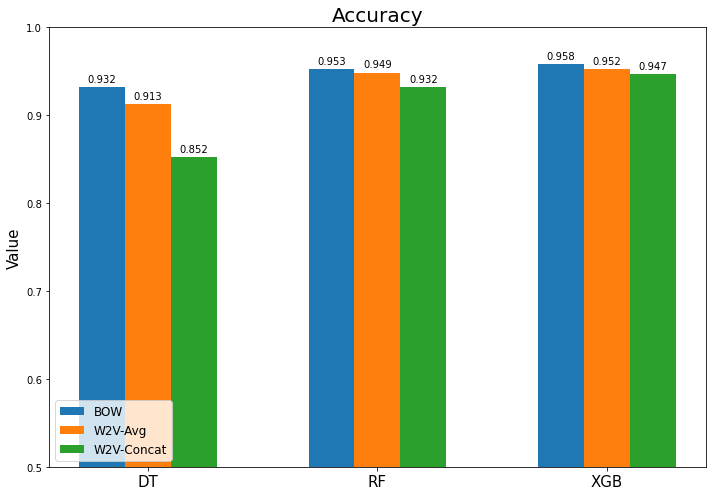

In [30]:
# Labels
labels = ['DT', 'RF', 'XGB']

# Data
DT = results_df.loc[results_df['Test'] == 'BOW']['Accuracy'].values
RF = results_df.loc[results_df['Test'] == 'W2V-Avg']['Accuracy'].values
XGB = results_df.loc[results_df['Test'] == 'W2V-Concat']['Accuracy'].values

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Create plot
fig, ax = plt.subplots(figsize=(10,7))

# Locate bar graphs
rects1 = ax.bar(x - width, DT, width, label='BOW')
rects2 = ax.bar(x, RF, width, label='W2V-Avg')
rects3 = ax.bar(x + width, XGB, width, label='W2V-Concat')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value', fontsize=15)
ax.set_title("Accuracy", fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=15)
ax.set_ylim((0.5, 1))
ax.legend(loc=3, fontsize=12)

# Autolabel bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Label bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Plot
fig.tight_layout()
fig.savefig('./results/accuracy.png')
plt.show()